# Application exploratory analysis

This notebook contains the main exploratory analysis of CAIRE's results presented in the paper.

It has been modified slightly from the original notebook: absolute paths have been anonymized, some additional explanatory comments have been added, and extraneous sections have been deleted.

In [2]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
from scipy.special import erf
from scipy.stats import norm, binomtest, false_discovery_control, spearmanr, pearsonr
from sklearn import metrics as skl_metrics
from Bio import SeqIO


# Set (Bayesian) p-value threshold.
thresh = 0.05
# Save figures.
save = True

### Load data

Below, CAIRE_PATH is the path to the output of output of running cross_validate.sh (it is a folder produced by aim, with the format '{random-words}-{random-hash}'). Similarly, NOSELECT_PATH is the output of cross_validate_noselect.sh.  BASE_PATH is to the folder containing the individual CAIRE model runs produced by cross_validate.sh. 

SNYDER_PATH is to the folder containing the preprocessed Snyder et al. data.

In [17]:
# CAIRE model.
cv_local_dir = CAIRE_PATH
results_file = os.path.join(cv_local_dir, 'cv_results.pkl')
with open(results_file, 'rb') as f:
    cv_results = pickle.load(f)
    local_dirs = pickle.load(f)
    bind_effects = pickle.load(f)
    hits = pickle.load(f)
    natural_effects = pickle.load(f)
    outcomes = pickle.load(f)
    select_embeds = pickle.load(f)
est_effect_df = pd.read_csv(os.path.join(root, local_dirs[0], 'est_effect.csv'))
patients = est_effect_df['patient']
mhc_class_1_eval = est_effect_df['mhc_class_1_eval']
mhc_class_2_eval = est_effect_df['mhc_class_2_eval']

In [18]:
# Alternative model (uncorrected).
cv_local_dir_alt = NOSELECT_PATH
results_file_alt = os.path.join(cv_local_dir_alt, 'cv_results.pkl')
with open(results_file_alt, 'rb') as f:
    cv_results_alt = pickle.load(f)
    _ = pickle.load(f)
    bind_effects_alt = pickle.load(f)
bind_effects_mn_alt = np.mean(bind_effects_alt, axis=1)
bind_effects_sd_alt = np.std(bind_effects_alt, axis=1)
logp_all_alt = norm(loc=np.abs(bind_effects_mn_alt), scale=bind_effects_sd_alt).logcdf(0)

In [19]:
# Load MIRA information.
mira_files = ['peptide-ci', 'peptide-cii']
mira_folder = SNYDER_PATH
mira_data = {}
for ke in mira_files:
    mira_detail_f = os.path.join(mira_folder, ke + '.csv')
    mira_data[ke] = pd.read_csv(mira_detail_f)

In [20]:
# Load sequence length information and covariate information.
with h5py.File('SNYDER_PATH/igor-snyder/preprocessed_igor.hdf5', 'r') as h5f:
    seq_lens = np.argmax(h5f['mira']['seq_aa'][:], axis=-1)
    covariates = h5f['covariates'][:]

In [21]:
# Check sizes:
print('Hits: ', sum([len(mira_data[ke]) for ke in mira_files]), 'confirm: ', sum(hits))
print('Non-hits: ', sum(1 - hits))

Hits:  32770 confirm:  32770
Non-hits:  10691826


### Predictive results

In [8]:
outcome_r2 = np.array([result['outcome_r2_test'] for result in cv_results])
outcome_r2_validate = np.array([result['outcome_r2_validate'] for result in cv_results])
treatment_explain = np.array([result['outcome_treatment_explained_test'] for result in cv_results])
confound_explain = np.array([result['outcome_confound_explained_test'] for result in cv_results])

outcome_r2_alt = np.array([result['outcome_r2_test'] for result in cv_results_alt])
outcome_r2_validate_alt = np.array([result['outcome_r2_validate'] for result in cv_results_alt])
treatment_explain_alt = np.array([result['outcome_treatment_explained_test'] for result in cv_results_alt])
confound_explain_alt = np.array([result['outcome_confound_explained_test'] for result in cv_results_alt])

Text(0, 0.5, 'confounder variance explained')

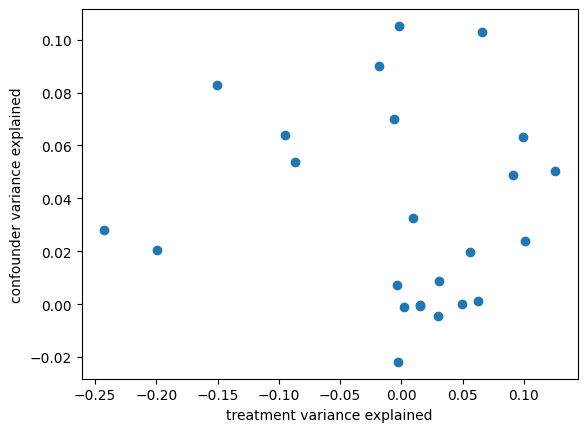

In [29]:
plt.scatter(treatment_explain, confound_explain)
plt.xlabel('treatment variance explained')
plt.ylabel('confounder variance explained')

Text(0, 0.5, 'outcome r2')

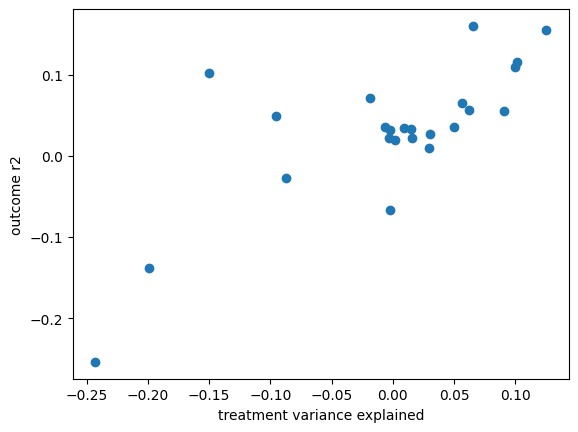

In [30]:
plt.scatter(treatment_explain, outcome_r2)
plt.xlabel('treatment variance explained')
plt.ylabel('outcome r2')

In [92]:
print('median outcome r2', np.median(outcome_r2))
print('median treatment explain', np.median(treatment_explain))
print('median confound explain', np.median(confound_explain))

median outcome r2 0.034676194
median treatment explain 0.012171030044555664
median confound explain 0.026095658540725708


In [94]:
print('median outcome r2', np.median(outcome_r2_alt))
print('median treatment explain', np.median(treatment_explain_alt))

median outcome r2 0.03058508
median treatment explain 0.03136599063873291


### Binder distributions

In [22]:
bind_effects_mn = np.mean(bind_effects, axis=1)
bind_effects_med = np.median(bind_effects, axis=1)
bind_effects_sd = np.std(bind_effects, axis=1)
logp_all = norm(loc=np.abs(bind_effects_mn), scale=bind_effects_sd).logcdf(0)

In [10]:
print('Negative fraction nonbinders nonsignificant, main:', np.mean(bind_effects_mn[(hits < 0.5)] < 0))
print('Negative fraction nonbinders nonsignificant, alt:', np.mean(bind_effects_mn_alt[(hits < 0.5)] < 0))
print('Negative fraction nonbinders, main:', np.mean(bind_effects_mn[(logp_all < np.log(thresh)) & (hits < 0.5)] < 0))
print('Negative fraction nonbinders, alt:', np.mean(bind_effects_mn_alt[(logp_all_alt < np.log(thresh)) & (hits < 0.5)] < 0))
print('Negative fraction binders, main:', np.mean(bind_effects_mn[(logp_all < np.log(thresh)) & (hits > 0.5) & mhc_class_1_eval] < 0))
print('Negative fraction binders, alt:', np.mean(bind_effects_mn_alt[(logp_all_alt < np.log(thresh)) & (hits > 0.5) & mhc_class_1_eval] < 0))

Negative fraction nonbinders nonsignificant, main: 0.5211841270144127
Negative fraction nonbinders nonsignificant, alt: 0.5804513653701435
Negative fraction nonbinders, main: 0.09019692606071936
Negative fraction nonbinders, alt: 0.7008996902823389
Negative fraction binders, main: 0.19484240687679083
Negative fraction binders, alt: 0.7664


In [70]:
print('Negative fraction binders nonsignificant all classes, main:', 
      np.mean(bind_effects_mn[(hits > 0.5)] < 0))
print('Small positive fraction binders nonsignificant all classes, main:', 
      np.mean((bind_effects_mn[(hits > 0.5)] < 0.3) & (bind_effects_mn[(hits > 0.5)] >= 0)))

Negative fraction binders nonsignificant all classes, main: 0.595575221238938
Small positive fraction binders nonsignificant all classes, main: 0.3688434543790052


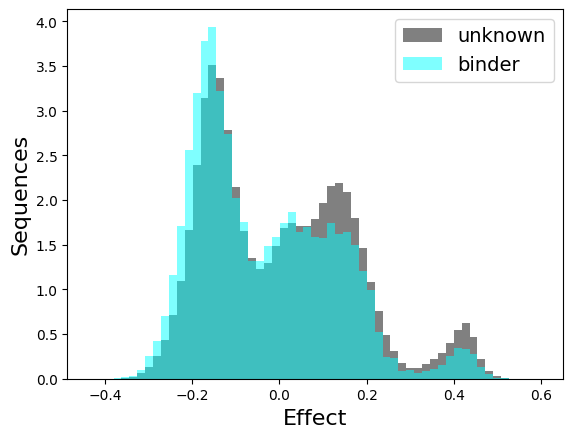

In [20]:
# hits versus non-hits
mcind = mhc_class_1_eval
hits_sub = hits[mcind]
bem_sub = bind_effects_mn[mcind]
lpa_sub = logp_all[mcind]

combine = np.concatenate([bem_sub[hits_sub < 0.5], bem_sub[hits_sub > 0.5]])
fd_width = 2 * (np.quantile(combine, 0.75) - np.quantile(combine, 0.25)) / (
        (np.minimum(np.sum(hits_sub < 0.5), np.sum(hits_sub > 0.5))) ** (1/3))
bin_lim = [np.min(combine), np.max(combine)]
bins = np.linspace(bin_lim[0], bin_lim[1], int((bin_lim[1] - bin_lim[0])/fd_width))

plt.hist(bem_sub[(hits_sub < 0.5)], color='gray', bins=bins, density=True, label='unknown');
plt.hist(bem_sub[(hits_sub > 0.5)], color='cyan', alpha=0.5, bins=bins, density=True, label='binder');
plt.legend(fontsize=14, loc='upper right')
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Sequences', fontsize=16)
if save:
    plt.savefig('saved_figs/binder_unknown_distr.pdf')

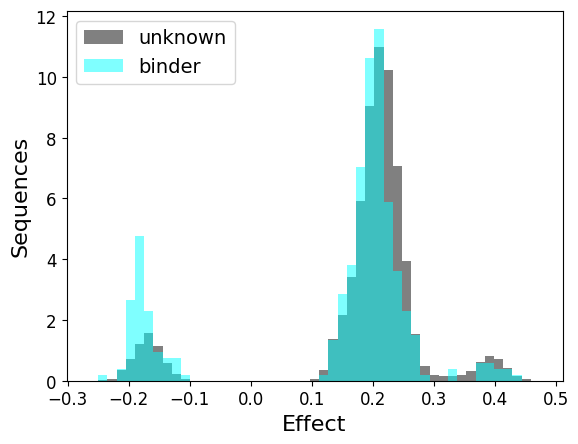

In [19]:
# Significant hits versus significant non-hits
mcind = mhc_class_1_eval
hits_sub = hits[mcind]
bem_sub = bind_effects_mn[mcind]
lpa_sub = logp_all[mcind]

signif_hit_effect = bem_sub[(lpa_sub < np.log(thresh)) & (hits_sub > 0.5)]
signif_nonhit_effect = bem_sub[(lpa_sub < np.log(thresh)) & (hits_sub < 0.5)]
combine = np.concatenate([signif_hit_effect, signif_nonhit_effect])
fd_width = 2 * (np.quantile(combine, 0.75) - np.quantile(combine, 0.25)) / (
        (np.minimum(len(signif_hit_effect), len(signif_nonhit_effect))) ** (1/3))
bin_lim = [np.min(combine), np.max(combine)]
bins = np.linspace(bin_lim[0], bin_lim[1], int((bin_lim[1] - bin_lim[0])/fd_width))

plt.hist(signif_nonhit_effect, color='gray', bins=bins, density=True, label='unknown')[1];
plt.hist(signif_hit_effect, color='cyan', alpha=0.5, bins=bins, density=True, label='binder')[1];
plt.legend(fontsize=14, loc='upper left')
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Sequences', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
if save:
    plt.savefig('saved_figs/binder_unknown_distr_significant.pdf')

### Effect distribution

In [131]:
print('non-hits', np.sum(hits < 0.5))
print('significant non-hits', np.sum((logp_all < np.log(thresh)) & (hits < 0.5)))
print('fraction significant', np.sum((logp_all < np.log(thresh)) & (hits < 0.5))/np.sum(hits < 0.5))

non-hits 10691826
significant non-hits 171181
fraction significant 0.01601045508971059


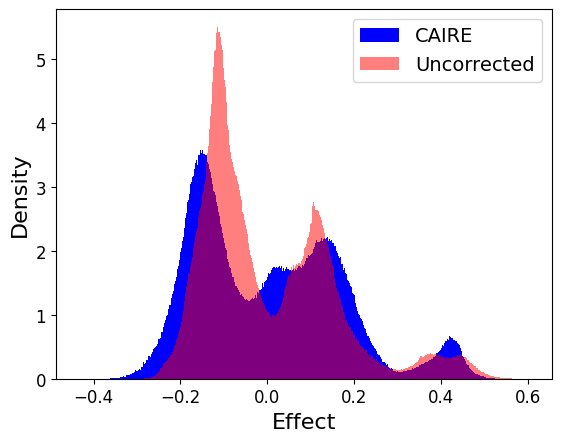

In [110]:
# All non-hits
combine = np.concatenate([bind_effects_mn[hits < 0.5], bind_effects_mn_alt[hits < 0.5]])
# Freedman-Diaconis rule, with interquartile range from combined dataset, and n from individual size.
fd_width = 2 * (np.quantile(combine, 0.75) - np.quantile(combine, 0.25)) / (np.sum(hits < 0.5) ** (1/3))
bin_lim = [np.min(combine), np.max(combine)]
bins = np.linspace(bin_lim[0], bin_lim[1], int((bin_lim[1] - bin_lim[0])/fd_width))
plt.hist(bind_effects_mn[hits < 0.5], bins=bins, density=True, label='CAIRE', color='blue');
plt.hist(bind_effects_mn_alt[hits < 0.5], bins=bins, density=True, alpha=0.5, label='Uncorrected', color='red');
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if save:
    plt.savefig('saved_figs/heldout_effect_all.pdf')

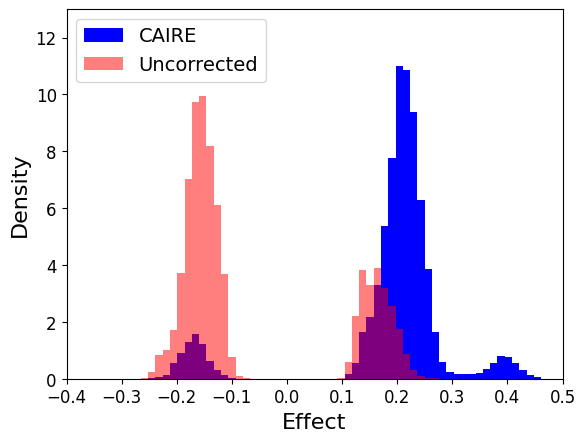

In [118]:
# Significant non-hits
effect_caire = bind_effects_mn[(logp_all < np.log(thresh)) & (hits < 0.5)]
effect_uncorrect = bind_effects_mn_alt[(logp_all_alt < np.log(thresh)) & (hits < 0.5)]
combine = np.concatenate([effect_caire, effect_uncorrect])

fd_width = 2 * (np.quantile(combine, 0.75) - np.quantile(combine, 0.25)) / (
        np.minimum(len(effect_caire), len(effect_uncorrect)) ** (1/3))
bin_lim = [np.min(combine), np.max(combine)]
bins = np.linspace(bin_lim[0], bin_lim[1], int((bin_lim[1] - bin_lim[0])/fd_width))

plt.hist(effect_caire, bins=bins, density=True, label='CAIRE', color='blue')
plt.hist(effect_uncorrect, bins=bins, density=True, alpha=0.5, label='Uncorrected', color='red');
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 13])
plt.xlim([-0.4, 0.5])
if save:
    plt.savefig('saved_figs/heldout_effect_signif.pdf')

### Effect distribution within and across patients

In [25]:
# Effect distribution across patient outcomes.
natural_effect_summary = dict()
natural_effects_mn = np.mean(natural_effects, axis=-1)
natural_effects_sd = np.std(natural_effects, axis=-1)
natural_effects_logp = norm(loc=np.abs(natural_effects_mn), scale=natural_effects_sd).logcdf(0)

effect_vals = {}
effect_vals_signif = {}
effect_vals_patient_mn = {}
effect_vals_signif_patient_mn = {}
effect_vals_signif_patient_var = {}
out_n = []
for rout in np.unique(outcomes):
    out_ind = np.isclose(outcomes.squeeze(), rout)
    if rout < -0.5:
        out_label = 'severe'
    elif rout > 0.5:
        out_label = 'mild'
    else:
        out_label = 'moderate'

    natural_effects_mn_out = natural_effects_mn[out_ind]
    natural_effects_signif_out = natural_effects_logp[out_ind] < np.log(thresh)
    
    effect_vals[out_label] = natural_effects_mn_out.reshape([-1])
    out_n.append(len(effect_vals[out_label]))
    effect_vals_signif[out_label] = effect_vals[out_label][natural_effects_signif_out.reshape([-1])]

    effect_vals_patient_mn[out_label] = np.mean(natural_effects_mn_out, axis=1)
    effect_vals_signif_patient_mn[out_label] = np.zeros_like(effect_vals_patient_mn[out_label])
    effect_vals_signif_patient_var[out_label] = np.zeros_like(effect_vals_patient_mn[out_label])
    for j in range(np.sum(out_ind)):
        effect_vals_signif_patient_mn[out_label][j] = np.mean(
            natural_effects_mn_out[j][natural_effects_signif_out[j]])
        effect_vals_signif_patient_var[out_label][j] = np.var(
            natural_effects_mn_out[j][natural_effects_signif_out[j]])


out_colors = {'mild': 'green', 'moderate': 'purple', 'severe': 'orange'}

V[E[ATE]]: 0.017775582
E[V[ATE]]: 0.12052335
E[|10 E[ATE]|] 0.13252623


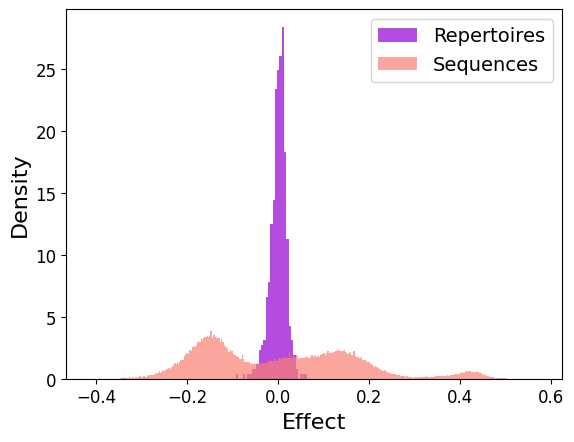

In [39]:
combined_mn = np.concatenate([elem for elem in effect_vals_patient_mn.values()])
combined_all = np.concatenate([elem for elem in effect_vals.values()])
plt.hist(combined_mn, color='darkviolet', density=True, label='Repertoires',
         bins='fd', alpha=0.7)
plt.hist(combined_all, color='salmon', density=True, label='Sequences', 
         alpha=0.7, bins='fd')
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16);
if save:
    plt.savefig('saved_figs/effect_distr_within_v_across.pdf')
print('V[E[ATE]]:', np.sqrt(np.var(combined_mn)))
print('E[V[ATE]]:', np.sqrt(np.mean(np.concatenate([elem for elem in effect_vals_signif_patient_var.values()]))))
print('E[|10 E[ATE]|]', np.mean(10 * np.abs(combined_mn)))

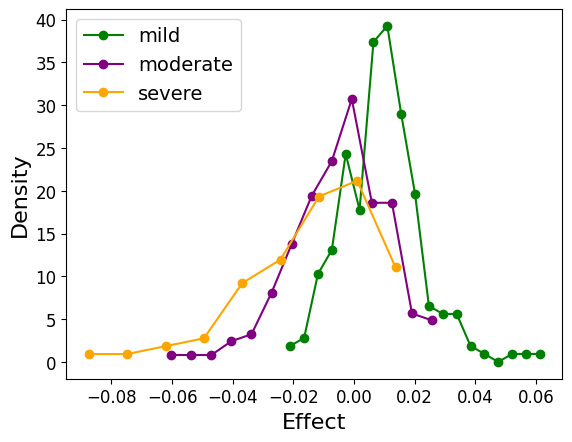

In [41]:

for out_label in ['mild', 'moderate', 'severe']:
    bin_vals, bins = np.histogram(effect_vals_patient_mn[out_label], 
                                  density=True, bins='fd')
    plt.plot(bins[:-1] + (bins[1]-bins[0])/2, bin_vals, marker='o',
             color=out_colors[out_label], label=out_label)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16);
if save:
    plt.savefig('saved_figs/effect_distr_patient_average_outcome.pdf')

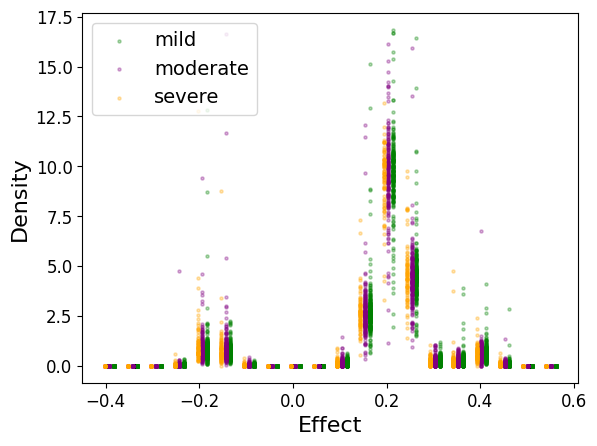

In [33]:


for rout in np.unique(outcomes):
    if rout > 0.5:
        out_label = 'mild'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
natural_effects_signif_out = natural_effects_logp[out_ind] < np.log(thresh)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects[natural_effects_signif_out[j]], bins=bins, density=True)[0]
    plt.scatter(bin_center + np.diff(bins)[0]/5, bin_vals, 
                color='green', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

for rout in np.unique(outcomes):
    if rout < 0.5 and rout > -0.5:
        out_label = 'moderate'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
natural_effects_signif_out = natural_effects_logp[out_ind] < np.log(thresh)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects[natural_effects_signif_out[j]], bins=bins, density=True)[0]
    plt.scatter(bin_center, bin_vals, 
                color='purple', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

for rout in np.unique(outcomes):
    if rout < -0.5:
        out_label = 'severe'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
natural_effects_signif_out = natural_effects_logp[out_ind] < np.log(thresh)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects[natural_effects_signif_out[j]], bins=bins, density=True)[0]
    plt.scatter(bin_center - np.diff(bins)[0]/5, bin_vals,
                color='orange', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16)
if save:
    plt.savefig('saved_figs/effect_distr_by_outcome_per_patient_signif.pdf')

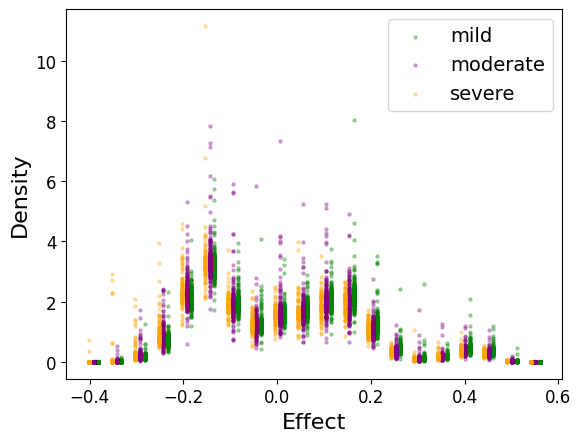

In [11]:
for rout in np.unique(outcomes):
    if rout > 0.5:
        out_label = 'mild'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects, bins=bins, density=True)[0]
    plt.scatter(bin_center + np.diff(bins)[0]/5, bin_vals, 
                color='green', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

for rout in np.unique(outcomes):
    if rout < 0.5 and rout > -0.5:
        out_label = 'moderate'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects, bins=bins, density=True)[0]
    plt.scatter(bin_center, bin_vals, 
                color='purple', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

for rout in np.unique(outcomes):
    if rout < -0.5:
        out_label = 'severe'
        break
out_ind = np.isclose(outcomes.squeeze(), rout)
bin_lim = [np.min(natural_effects_mn), np.max(natural_effects_mn)]
bins = np.linspace(bin_lim[0], bin_lim[1], 21)
bin_center = bins[:-1] + np.diff(bins)[0]/2
for j, patient_effects in enumerate(natural_effects_mn[out_ind]):
    bin_vals = np.histogram(patient_effects, bins=bins, density=True)[0]
    plt.scatter(bin_center - np.diff(bins)[0]/5, bin_vals,
                color='orange', alpha=0.3, label=[out_label, None][int(j > 0)],
                s=5)

plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Effect', fontsize=16)
plt.ylabel('Density', fontsize=16)
if save:
    plt.savefig('saved_figs/effect_distr_by_outcome_per_patient.pdf')

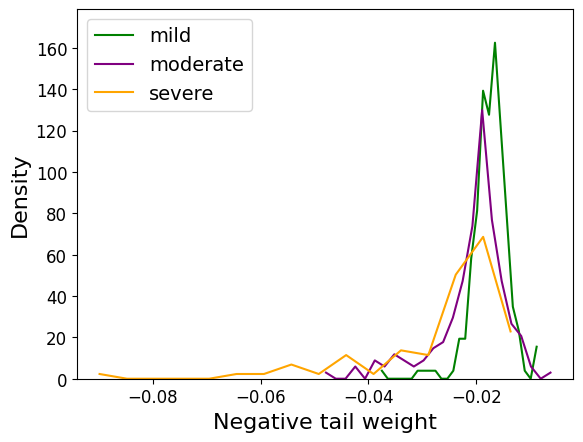

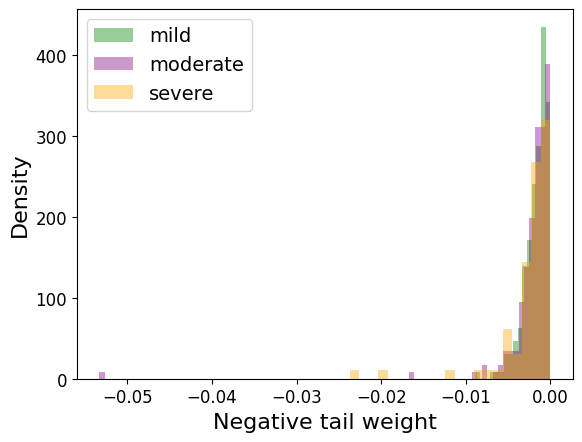

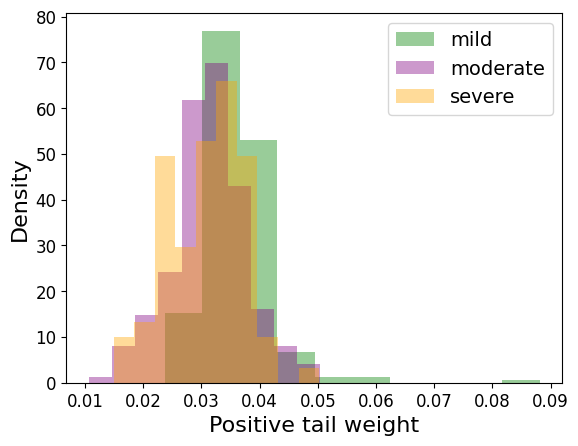

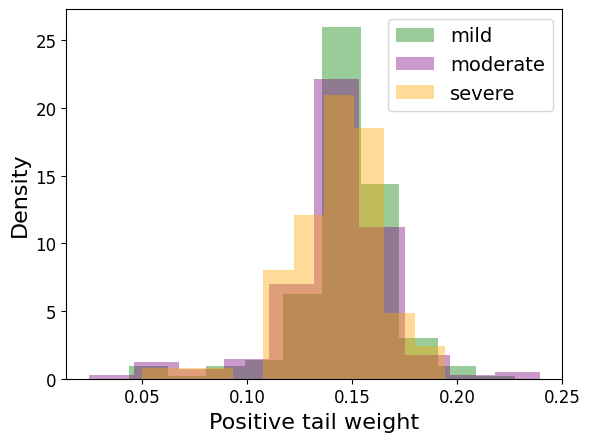

In [48]:
neg_cut = -0.2
pos_cut = 0.2
neg_frac = {'mild': [], 'moderate': [], 'severe': []}
neg_frac_signif = {'mild': [], 'moderate': [], 'severe': []}
pos_frac = {'mild': [], 'moderate': [], 'severe': []}
pos_frac_signif = {'mild': [], 'moderate': [], 'severe': []}
for j, patient_effects in enumerate(natural_effects_mn):
    rout = outcomes[j].squeeze()
    if rout < -0.5:
        out_label = 'severe'
    elif rout > 0.5:
        out_label = 'mild'
    else:
        out_label = 'moderate'

    neg_frac[out_label].append(np.mean((patient_effects < neg_cut) * patient_effects))
    pos_frac[out_label].append(np.mean((patient_effects > pos_cut) * patient_effects))

    patient_effect_signif = patient_effects[natural_effects_logp[j] < np.log(thresh)]
    neg_frac_signif[out_label].append(np.mean((patient_effect_signif < neg_cut) * patient_effect_signif))
    pos_frac_signif[out_label].append(np.mean((patient_effect_signif > pos_cut) * patient_effect_signif))

plt.figure()
colors = {'mild': 'green', 'moderate': 'purple', 'severe': 'orange'}
max_val = 0.
for out_label in ['mild', 'moderate', 'severe']:
    bin_vals, bins = np.histogram(neg_frac[out_label], density=True, bins='fd')
    plt.plot(bins[:-1] + (bins[1]-bins[0])/2, bin_vals, # marker='o',
             color=colors[out_label], label=out_label)
    max_val = np.maximum(max_val, np.max(bin_vals))
    #plt.hist(neg_frac[out_label], density=True, alpha=0.4, label=out_label,
    #         color=colors[out_label], bins='fd')
plt.xlabel('Negative tail weight', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, max_val*1.1])
if save:
    plt.savefig('saved_figs/negative_tail_weight_by_outcome.pdf')

plt.figure()
colors = {'mild': 'green', 'moderate': 'purple', 'severe': 'orange'}
for out_label in ['mild', 'moderate', 'severe']:
    plt.hist(neg_frac_signif[out_label], density=True, alpha=0.4, label=out_label,
             color=colors[out_label], bins='fd')
plt.xlabel('Negative tail weight', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if save:
    plt.savefig('saved_figs/negative_tail_weight_by_outcome_signif.pdf')
    
plt.figure()
colors = {'mild': 'green', 'moderate': 'purple', 'severe': 'orange'}
for out_label in ['mild', 'moderate', 'severe']:
    plt.hist(pos_frac[out_label], density=True, alpha=0.4, label=out_label,
             color=colors[out_label])
plt.xlabel('Positive tail weight', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if save:
    plt.savefig('saved_figs/positive_tail_weight_by_outcome.pdf')

plt.figure()
colors = {'mild': 'green', 'moderate': 'purple', 'severe': 'orange'}
for out_label in ['mild', 'moderate', 'severe']:
    plt.hist(pos_frac_signif[out_label], density=True, alpha=0.4, label=out_label,
             color=colors[out_label])
plt.xlabel('Positive tail weight', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
if save:
    plt.savefig('saved_figs/positive_tail_weight_by_outcome_signif.pdf')

### Extract therapeutic and target candidates

In [63]:
signif_candidates = (logp_all < np.log(thresh)) & (bind_effects_mn > 0.3) & (hits > 0.5)
print('Total TCR candidates', np.sum(signif_candidates))

Total TCR candidates 18


In [64]:
signif_neg_candidates = (logp_all < np.log(thresh)) & (bind_effects_mn < -0.1) & (hits > 0.5)
print('Total TCR negative candidates', np.sum(signif_neg_candidates))

Total TCR negative candidates 73


In [67]:
# Print top examples for latex.
#n_examples = 20
rnks = np.argsort(bind_effects_mn[hits > 0.5] * (logp_all[hits > 0.5] < np.log(thresh)))
top = -1
for top in [False, True]:
    if top:
        n_examples = np.sum(signif_candidates)
        inds = np.flip(rnks[-n_examples:])
        print('Most positive effects')
    else:
        n_examples = np.sum(signif_neg_candidates)
        inds = rnks[:n_examples]
        print('Most negative effects')
    seq_ind = 0
    for ke in mira_files:
        if ke == 'peptide-ci':
            print('Class I')
        elif ke == 'peptide-cii':
            print('Class II')
        print('\\\\ \hline')
        for j in inds:
            if j >= seq_ind and j < (seq_ind + len(mira_data[ke])):
                candidate_effect = bind_effects_mn[hits > 0.5][j]
                print('{:.3f}'.format(candidate_effect), '&', 
                      mira_data[ke]['TCR BioIdentity'].iloc[j-seq_ind].split('+')[0], '&',
                      '+'.join(mira_data[ke]['TCR BioIdentity'].iloc[j-seq_ind].split('+')[1:]), '&',
                      mira_data[ke]['Amino Acids'].iloc[j-seq_ind], '&',
                      '[{},{}]'.format(mira_data[ke]['Start Index in Genome'].iloc[j-seq_ind], 
                                       mira_data[ke]['End Index in Genome'].iloc[j-seq_ind]),
                      '\\\\')  # .split('+')[0]
        seq_ind += len(mira_data[ke])

Most negative effects
Class I
\\ \hline
-0.236 & CASSFDPPGSDEQYF & TCRBV12-X+TCRBJ02-07 & HTTDPSFLGRY & [5171,5203] \\
-0.207 & CASSPGQGSYEQYF & TCRBV05-04+TCRBJ02-07 & LLTDEMIAQY,LTDEMIAQY,LTDEMIAQYT,VLPPLLTDEMIAQY & [24140,24184] \\
-0.207 & CASSPGQGSYEQYF & TCRBV05-04+TCRBJ02-07 & LLTDEMIAQY,LTDEMIAQY,LTDEMIAQYT,VLPPLLTDEMIAQY & [24140,24184] \\
-0.204 & CASSPRDAYDTQYF & TCRBV27-01+TCRBJ02-03 & HTTDPSFLGRY & [5171,5203] \\
-0.202 & CASSFDYQNPYEQYF & TCRBV28-01+TCRBJ02-07 & FLWLLWPVT,FLWLLWPVTL,LWLLWPVTL,LWPVTLACF,TLACFVLAAV,WLLWPVTLA,WPVTLACFVL & [26679,26732] \\
-0.200 & CASSQDARGPDEQYF & TCRBV04-03+TCRBJ02-07 & KAYNVTQAF & [29069,29095] \\
-0.199 & CASSPGGVTDTQYF & TCRBV06-04+TCRBJ02-03 & HTTDPSFLGRY & [5171,5203] \\
-0.198 & CASSLDSPDTQYF & TCRBV05-01+TCRBJ02-03 & GNYTVSCLPF,NYTVSCLPF,YTVSCLPFTI & [28122,28157] \\
-0.197 & CASSQGQGSYEQYF & TCRBV04-03+TCRBJ02-07 & AFLLFLVLI,FLAFLLFLV,FYLCFLAFL,FYLCFLAFLL,IDFYLCFLAF,IELSLIDFYL,LIDFYLCFL,LLFLVLIML,MIELSLIDFY,SLIDFYLCFL,YLCFLAFLL & [

### Set up genome annotations

The file sars_cov_2_genome_features.gb is downloaded from https://www.ncbi.nlm.nih.gov/nuccore/1798174254
It contains a reference SARS-CoV-2 genome from the beginning of the pandemic, along with annotated features. It appears to match the reference genome used to label epitope locations in the Snyder et al. study, well enough for the resolution of the plot (I found a few epitopes whose locations are off-by-one relative to the reference).

In [5]:
for record in SeqIO.parse("sars_cov_2_genome_features.gb", "genbank"):
    break

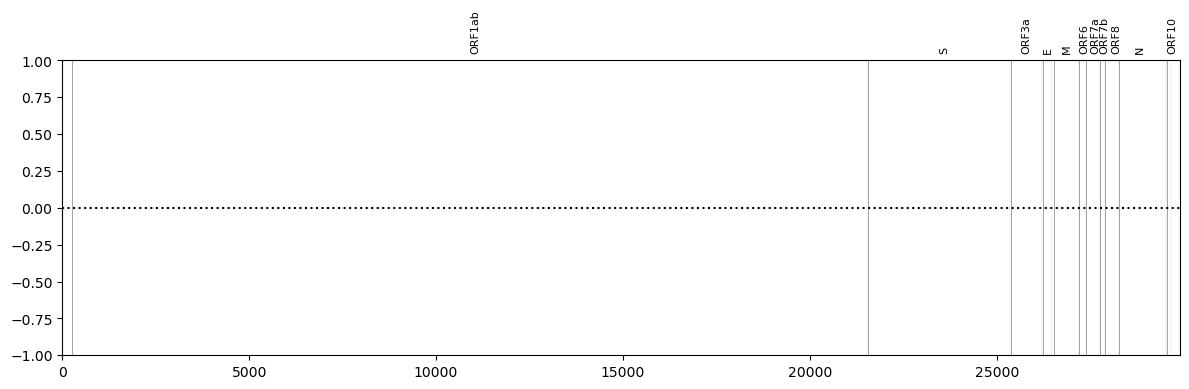

In [40]:
def annotate_genome(min_h, max_h, min_gap):
    for record in SeqIO.parse("sars_cov_2_genome_features.gb", "genbank"):
        break
    prev_loc = 0
    for feat in record.features:
        if feat.type == 'gene':
            plt.plot([feat.location.start, feat.location.start], [min_h, max_h], color='gray', linewidth=0.5)
            plt.plot([feat.location.end, feat.location.end], [min_h, max_h], color='gray', linewidth=0.1)
            if feat.qualifiers['gene'][0] in ['M', 'N', 'ORF3a']:
                text_loc = feat.location.start + (feat.location.end - feat.location.start)/3
            elif feat.qualifiers['gene'][0] in ['ORF1ab', 'S']:
                text_loc = feat.location.start + (feat.location.end - feat.location.start)/2
            else:
                text_loc = np.maximum(feat.location.start, prev_loc+min_gap)
            plt.text(text_loc, max_h*1.05, feat.qualifiers['gene'][0],
                    rotation=90, horizontalalignment='left', verticalalignment='bottom', fontsize=8)
            prev_loc = feat.location.start
        elif feat.type == 'source':
            plt.xlim([feat.location.start, feat.location.end])
    plt.plot([0, len(record.seq)], [0, 0], 'k:')
    plt.ylim([min_h, max_h])
    plt.tight_layout()
    
plt.figure(figsize=(12, 4))
annotate_genome(-1, 1, 300)

### Per-epitope TCR effects

In [23]:
# Collect antigens
genome_locs = np.concatenate([np.array(mira_data[ke]['Start Index in Genome']) for ke in mira_files])
hit_effect_mn = np.mean(bind_effects, axis=1)[hits > 0.5]
hit_effect_sd = np.std(bind_effects, axis=1)[hits > 0.5]
logp = norm(loc=np.abs(hit_effect_mn), scale=hit_effect_sd).logcdf(0)
signif = logp < np.log(thresh)

antigens = []
for ke in mira_files:
    if 'Amino Acid' in mira_data[ke]:
        aa_col = 'Amino Acid'
    else:
        aa_col = 'Amino Acids'
    antigens += list(set(mira_data[ke][aa_col]))
    antigens
# Label antigens
antigen_ind = np.zeros(sum(hits), dtype=np.int32)
antigen_loc = np.zeros(len(antigens))
antigen_len = np.zeros(len(antigens))
antigen_loc_details = np.zeros((len(antigens), 2))
f_ind = 0
for ke in mira_files:
    if 'Amino Acid' in mira_data[ke]:
        aa_col = 'Amino Acid'
    else:
        aa_col = 'Amino Acids'
    for j in range(len(mira_data[ke])):
        ant_ind = antigens.index(mira_data[ke][aa_col].iloc[j])
        antigen_ind[j + f_ind] = ant_ind
        antigen_len[ant_ind] = (mira_data[ke]['End Index in Genome'].iloc[j] - 
                                mira_data[ke]['Start Index in Genome'].iloc[j])
        antigen_loc[ant_ind] = mira_data[ke]['Start Index in Genome'].iloc[j] + antigen_len[ant_ind]/2
        antigen_loc_details[ant_ind, 0] = mira_data[ke]['Start Index in Genome'].iloc[j]
        antigen_loc_details[ant_ind, 1] = mira_data[ke]['End Index in Genome'].iloc[j]
    f_ind += len(mira_data[ke])

antigen_effect_mn = np.array([np.mean(hit_effect_mn[signif & (antigen_ind == k)]) 
                              for k in range(len(antigens))])
antigen_sign_mn = np.array([np.mean(np.sign(hit_effect_mn[signif & (antigen_ind == k)])) 
                            for k in range(len(antigens))])
antigen_poseffect_sum = np.array([np.sum(hit_effect_mn[signif & (antigen_ind == k)] > 0) 
                                 for k in range(len(antigens))])
antigen_binders = np.array([np.sum(signif & (antigen_ind == k))
                               for k in range(len(antigens))])

btest = np.ones(len(antigen_binders))
for j in range(len(antigen_binders)):
    if antigen_binders[j] > 0:
        assert antigen_poseffect_sum[j] <= antigen_binders[j]
        btest[j] = binomtest(antigen_poseffect_sum[j], antigen_binders[j]).pvalue
btest = false_discovery_control(btest)

/home/enw/miniconda3/envs/jupy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/enw/miniconda3/envs/jupy/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


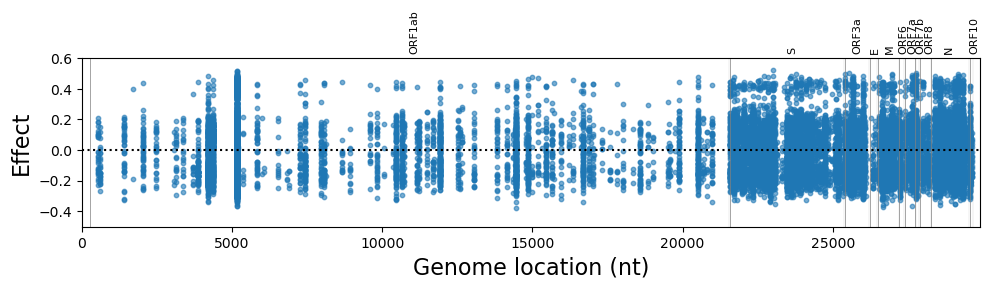

In [50]:
plt.figure(figsize=(10, 3))
plt.scatter(genome_locs, hit_effect_mn, s=10, alpha=0.6)
annotate_genome(-.5, .6, 300)
plt.xlabel('Genome location (nt)', fontsize=16)
plt.ylabel('Effect', fontsize=16)
plt.tight_layout()
if save:
    plt.savefig('saved_figs/binder_all_effect_loc.pdf')

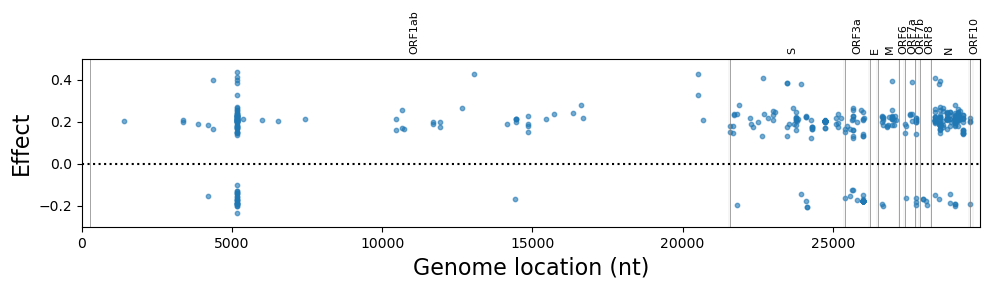

In [49]:
plt.figure(figsize=(10, 3))
plt.scatter(genome_locs[signif], hit_effect_mn[signif], s=10, alpha=0.6)
annotate_genome(-.3, .5, 300)
plt.xlabel('Genome location (nt)', fontsize=16)
plt.ylabel('Effect', fontsize=16)
plt.tight_layout()
if save:
    plt.savefig('saved_figs/binder_significant_effect_loc.pdf')

Text(0, 0.5, 'Mean binder effect sign')

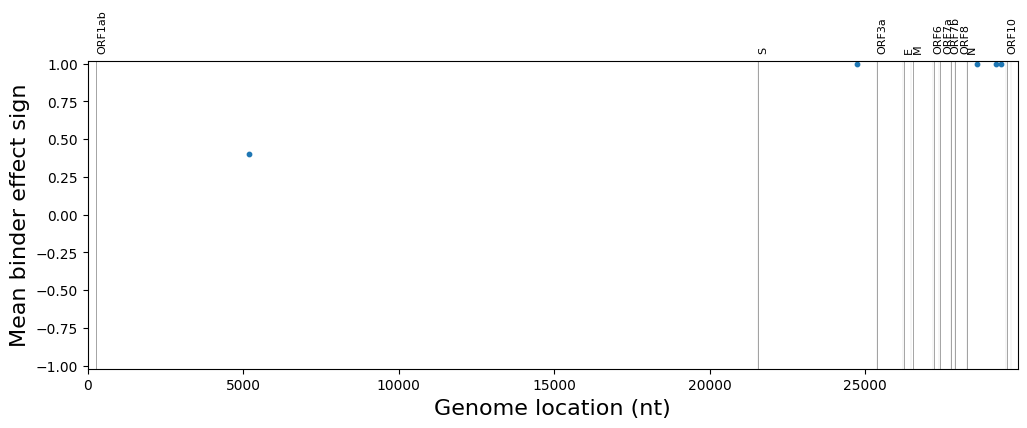

In [16]:
plt.figure(figsize=(12, 4))
plt.scatter(antigen_loc[(btest < thresh) & (antigen_len < 90)],
            antigen_sign_mn[(btest < thresh) & (antigen_len < 90)], s=10)
annotate_genome(-1.02, 1.02, 300)
plt.xlabel('Genome location (nt)', fontsize=16)
plt.ylabel('Mean binder effect sign', fontsize=16)

In [17]:
for j in range(len(antigen_loc)):
    if btest[j] < thresh and antigen_len[j] < 90:
        print('{:.2f}'.format(antigen_sign_mn[j]), '&', antigens[j], '&', int(antigen_loc_details[j, 0]), '-', int(antigen_loc_details[j, 1]), '\\\\')

0.40 & HTTDPSFLGRY & 5171 - 5203 \\
1.00 & APHGVVFL,APHGVVFLHV,GVVFLHVTY,VVFLHVTYV & 24728 - 24766 \\
1.00 & LSPRWYFYY,SPRWYFYYL & 28583 - 28612 \\
1.00 & AYKTFPPTEPK,KTFPPTEPK & 29348 - 29380 \\
1.00 & APSASAFFGM,AQFAPSASA,ASAFFGMSR,SASAFFGMSR & 29186 - 29230 \\


In [40]:
# check on NP_105-113 antigen, associated with lower severity
np_prot = """MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLPNNTASWFTALTQHGKEDLKFPRGQGVPINTNSSPDDQIGYYRRATRRIRGGDGKMKDLSPRWYFYYLGTGPEAGLPYGANKDGIIWVATEGALNTPKDHIGTRNPANNAAIVLQLPQGTTLPKGFYAEGSRGGSQASSRSSSRSRNSSRNSTPGSSRGTSPARMAGNGGDAALALLLLDRLNQLESKMSGKGQQQQGQTVTKKSAAEASKKPRQKRTATKAYNVTQAFGRRGPEQTQGNFGDQELIRQGTDYKHWPQIAQFAPSASAFFGMSRIGMEVTPSGTWLTYTGAIKLDDKDPNFKDQVILLNKHIDAYKTFPPTEPKKDKKKKADETQALPQRQKKQQTVTLLPAADLDDFSKQLQQSMSSADSTQA"""
print(np_prot[104:113])
key_antigen = 29558 + 3 * 105
closest_antigen_to_key = np.argmin(np.abs(antigen_loc[(antigen_len < 90)] - key_antigen))
print(antigen_loc[(antigen_len < 90)][closest_antigen_to_key], key_antigen)

SPRWYFYYL
29649.0 29873


In [41]:
# Collect antigens for alt dataset
genome_locs = np.concatenate([np.array(mira_data[ke]['Start Index in Genome']) for ke in mira_files])
hit_effect_mn = np.mean(bind_effects_alt, axis=1)[hits > 0.5]
hit_effect_sd = np.std(bind_effects_alt, axis=1)[hits > 0.5]
logp = norm(loc=np.abs(hit_effect_mn), scale=hit_effect_sd).logcdf(0)
signif = logp < np.log(thresh)

antigens = []
for ke in mira_files:
    if 'Amino Acid' in mira_data[ke]:
        aa_col = 'Amino Acid'
    else:
        aa_col = 'Amino Acids'
    antigens += list(set(mira_data[ke][aa_col]))
    antigens
# Label antigens
antigen_ind = np.zeros(sum(hits), dtype=np.int32)
antigen_loc = np.zeros(len(antigens))
antigen_len = np.zeros(len(antigens))
antigen_loc_details = np.zeros((len(antigens), 2))
f_ind = 0
for ke in mira_files:
    if 'Amino Acid' in mira_data[ke]:
        aa_col = 'Amino Acid'
    else:
        aa_col = 'Amino Acids'
    for j in range(len(mira_data[ke])):
        ant_ind = antigens.index(mira_data[ke][aa_col].iloc[j])
        antigen_ind[j + f_ind] = ant_ind
        antigen_len[ant_ind] = (mira_data[ke]['End Index in Genome'].iloc[j] - 
                                mira_data[ke]['Start Index in Genome'].iloc[j])
        antigen_loc[ant_ind] = mira_data[ke]['Start Index in Genome'].iloc[j] + antigen_len[ant_ind]/2
        antigen_loc_details[ant_ind, 0] = mira_data[ke]['Start Index in Genome'].iloc[j]
        antigen_loc_details[ant_ind, 1] = mira_data[ke]['End Index in Genome'].iloc[j]
    f_ind += len(mira_data[ke])

antigen_effect_mn = np.array([np.mean(hit_effect_mn[signif & (antigen_ind == k)]) 
                              for k in range(len(antigens))])
antigen_sign_mn = np.array([np.mean(np.sign(hit_effect_mn[signif & (antigen_ind == k)])) 
                            for k in range(len(antigens))])
antigen_poseffect_sum = np.array([np.sum(hit_effect_mn[signif & (antigen_ind == k)] > 0) 
                                 for k in range(len(antigens))])
antigen_binders = np.array([np.sum(signif & (antigen_ind == k))
                               for k in range(len(antigens))])

btest = np.ones(len(antigen_binders))
for j in range(len(antigen_binders)):
    if antigen_binders[j] > 0:
        assert antigen_poseffect_sum[j] <= antigen_binders[j]
        btest[j] = binomtest(antigen_poseffect_sum[j], antigen_binders[j]).pvalue
btest = false_discovery_control(btest)

In [48]:
for j in range(len(antigen_loc)):
    if btest[j] < thresh and antigen_len[j] < 90:
        print('{:.2f}'.format(antigen_sign_mn[j]), '&', antigens[j], '&', int(antigen_loc_details[j, 0]), '-', int(antigen_loc_details[j, 1]), '\\\\')

-0.73 & HTTDPSFLGRY & 5171 - 5203 \\


### Compare latent confounder to covariates

In [11]:
from sklearn import linear_model, model_selection, manifold, gaussian_process, decomposition

In [18]:
# Age.
covariate_r2 = np.zeros(select_embeds.shape[2])
for j in range(select_embeds.shape[2]):
    nonmiss = covariates[:, 0] >= 0
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
            select_embeds[nonmiss, :, j], covariates[nonmiss, 0], test_size=0.125, random_state=(100 + j))
    clf = linear_model.BayesianRidge()
    clf.fit(X_train, Y_train)
    covariate_r2[j] = clf.score(X_test, Y_test)
    if j == np.argmax(outcome_r2):
        print(covariate_r2[j])
print('mean and median coeff of determination:', np.mean(covariate_r2), np.median(covariate_r2))
print('s.e. of mean', np.std(covariate_r2)/np.sqrt(len(covariate_r2)))
print('non missing', np.sum(nonmiss))

-0.02789453911391515
mean and median coeff of determination: 0.0041494156894591695 -0.0007690288091547481
s.e. of mean 0.008785028638959186
non missing 505


In [19]:
# gender.
gend_score = np.zeros(select_embeds.shape[2])
test_mn = np.zeros(select_embeds.shape[2])
for j in range(select_embeds.shape[2]):
    nonmiss = covariates[:, 1] >= 0
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
            select_embeds[nonmiss, :, j], covariates[nonmiss, 1], test_size=0.125, random_state=(100 + j))
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, Y_train)
    gend_score[j] = clf.score(X_test, Y_test)
    test_mn[j] = np.mean(Y_test)
print('mean and median accuracy:', np.mean(gend_score), np.median(gend_score))
print('s.e. accuracy:', np.std(gend_score)/np.sqrt(len(gend_score)))
print('mean value', np.mean(test_mn), np.median(test_mn))
print('nonmissing', np.sum(nonmiss))

mean and median accuracy: 0.4733072916666667 0.46875
s.e. accuracy: 0.013640190426700933
mean value 0.5110677083333334 0.53125
nonmissing 506


In [17]:
# ethnicity (non-Caucasian)
eth_score = np.zeros(select_embeds.shape[2])
test_mn = np.zeros(select_embeds.shape[2])
for j in range(select_embeds.shape[2]):
    nonmiss = covariates[:, 2] >= 0
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
            select_embeds[nonmiss, :, j], covariates[nonmiss, 2] == 0, test_size=0.125, random_state=(100 + j))
    clf = linear_model.LogisticRegression()
    clf.fit(X_train, Y_train)
    eth_score[j] = clf.score(X_test, Y_test)
    test_mn[j] = np.mean(Y_test)
print('mean and median accuracy:', np.mean(eth_score), np.median(eth_score))
print('s.e. accuracy:', np.std(eth_score)/np.sqrt(len(eth_score)))
print('mean value', np.mean(test_mn), np.median(test_mn))

mean and median accuracy: 0.8432539682539683 0.8253968253968254
s.e. accuracy: 0.008277110456867612
mean value 0.8432539682539683 0.8253968253968254


#### Correlation between confounder representations across model ensemble

In [23]:
dist_mat = np.sqrt(((select_embeds[:, None, :, :] - select_embeds[None, :, :, :])**2).sum(axis=2))
n = dist_mat.shape[0]
dist_mat_flat = np.zeros((int((n * n - n)/2), dist_mat.shape[2]))
si = 0
for j in range(dist_mat.shape[0]-1):
    for jj in range(j+1, dist_mat.shape[1]):
        dist_mat_flat[si] = dist_mat[j, jj]
        si += 1

In [26]:
corr_dist = np.zeros( int((dist_mat.shape[2] ** 2 - dist_mat.shape[2])/2))
corr_dist_p = np.zeros_like(corr_dist)
ki = 0
for k in range(dist_mat.shape[2]-1):
    for kk in range(k+1, dist_mat.shape[2]):
        spr = pearsonr(dist_mat_flat[:, k], dist_mat_flat[:, kk])
        corr_dist[ki] = spr.statistic
        corr_dist_p[ki] = spr.pvalue
        ki += 1

In [27]:
print(np.mean(corr_dist))
print(np.max(corr_dist_p))

0.698197188270397
0.0
